In [ ]:
# tpu 연결
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 144.6 MB 72 kB/s 
     |████████████████████████████████| 57 kB 3.0 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.290 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [ ]:
!pip install transformers
!pip install pytorch-lightning
!pip install sentencepiece

'''
!pip install pyyaml==5.1
!pip install torch==1.8.1 torchvision==0.9.1 torchtext==0.9.1 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!python -m pip install 'git+https://github.com/facebookresearch/mobile-vision.git'
'''

     |████████████████████████████████| 3.1 MB 8.9 MB/s 
     |████████████████████████████████| 895 kB 50.4 MB/s 
     |████████████████████████████████| 596 kB 54.4 MB/s 
     |████████████████████████████████| 59 kB 8.4 MB/s 
     |████████████████████████████████| 3.3 MB 57.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 524 kB 7.5 MB/s 
     |████████████████████████████████| 829 kB 83.9 MB/s 
     |████████████████████████████████| 132 kB 89.3 MB/s 
     |████████████████████████████████| 329 kB 80.3 MB/s 
     |████████████████████████████████| 1.1 MB 74.9 MB/s 
     |████████████████████████████████| 271 kB 82.4 MB/s 
     |████████████████████████████████| 192 kB 97.8 MB/s 
     |████████████████████████████████| 160 kB 87.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=a24db0a9b8e21f

"\n!pip install pyyaml==5.1\n!pip install torch==1.8.1 torchvision==0.9.1 torchtext==0.9.1 -f https://download.pytorch.org/whl/cu101/torch_stable.html\n!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'\n!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'\n!python -m pip install 'git+https://github.com/facebookresearch/mobile-vision.git'\n"

In [ ]:
import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
from pathlib import Path # 파일시스템의 경로를 단순한 문자열이 아닌 객체로 다루게 하는 것
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    MT5ForConditionalGeneration,
    T5Tokenizer
)
from tqdm.auto import tqdm

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import gc
import missingno as msno

import warnings

warnings.filterwarnings(action='ignore') 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

In [ ]:
#import torch_xla.core.xla_model as xm
#device = xm.xla_device()

In [ ]:
#device

device(type='xla', index=1)

In [ ]:
pl.seed_everything(42)


from google.colab import drive
drive.mount('/content/drive')

Global seed set to 42


Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/project3_nmt/train.csv')
dev = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/project3_nmt/dev.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/project3_nmt/test.csv')
test2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/project3_nmt/test2.csv')

In [ ]:
display(train.head(2))
display(dev.head(2))
display(test.head(2))
display(test2.head(2))

,sid,en,ko
0,train-0,Just use a LinearLayout instead.,그 대신 Linear Layout을 쓰는 게 낫다.
1,train-1,I made a seventy-eight today.,저는 오늘 78타를 쳤습니다.


,sid,en,ko
0,dev-0,Match up with Hello Carbot Megabold versus Met...,헬로카봇 메가볼들 대 매트론 K 컵스와의 대결이에요.
1,dev-1,Mr.Park sends his regards.,미스터 박이 대신 안부 전해 달라더군요.


,sid,en
0,test-0,I hope nothing happens to you.
1,test-1,"He'll adapt well, don't worry."


,sid,en
0,test2-0,They were chosen as the chief husband and the ...
1,test2-1,So I stopped the process of preparing my under...


In [ ]:
class NewSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        en_max_token_len: int = 80,
        ko_max_token_len: int = 80):

        self.tokenizer = tokenizer
        self.data = data
        self.en_max_token_len = en_max_token_len
        self.ko_max_token_len = ko_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        en = data_row['en']

        text_encoding = tokenizer(
            en,
            max_length=self.en_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        summary_encoding = tokenizer(
            data_row['ko'],
            max_length=self.ko_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )
        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100 # to make sure we have correct labels for T5 text generation

        return dict(
            en=en,
            ko=data_row['ko'],
            text_input_ids=text_encoding['input_ids'].flatten(),
            text_attention_mask=text_encoding['attention_mask'].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding['attention_mask'].flatten()

        )

In [ ]:

# next(iter(NewSummaryDataset(train, tokenizer,80,80)))

{'en': 'Just use a LinearLayout instead.',
 'ko': '그 대신 Linear Layout을 쓰는 게 낫다.',
 'labels': tensor([  1884,   4420,   3158,   8551,    372,    259,  86063,    611,  37494,
            988,    259,   2317,    259, 238734,   1654,    260,      1,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100]),
 'labels_attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(
            self,
            train_df: pd.DataFrame,
            test_df: pd.DataFrame,
            tokenizer: T5Tokenizer,
            batch_size: int = 8,
            en_max_token_len: int = 80,
            ko_max_token_len: int = 80
    ):

        super(NewsSummaryDataModule, self).__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.en_max_token_len = en_max_token_len
        self.ko_max_token_len = ko_max_token_len

    def setup(self, stage=None):
        self.train_dataset = NewSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.en_max_token_len,
            self.ko_max_token_len
        )
        self.test_dataset = NewSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.en_max_token_len,
            self.ko_max_token_len
        )
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

In [ ]:
MODEL_NAME = 'google/mt5-base'

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/702 [00:00<?, ?B/s]

In [ ]:
train.describe()

,sid,en,ko
count,150000,150000,150000
unique,150000,149901,149993
top,train-29787,Don't worry about it.,삼촌에게도 안부 전해주세요.
freq,1,2,2


In [ ]:
dev.describe()

,sid,en,ko
count,10000,10000,10000
unique,10000,10000,10000
top,dev-6711,Do I need a coin to use this cart?,우리는 병원으로 가는 차 안에서 수시로 연습했어요.
freq,1,1,1


In [ ]:
en_token_counts, ko_token_counts = [], []

for _, row in train.iterrows():
    en_token_count = len(tokenizer.encode(row['en']))
    en_token_counts.append(en_token_count)

    ko_token_count = len(tokenizer.encode(row['ko']))
    ko_token_counts.append(ko_token_count)

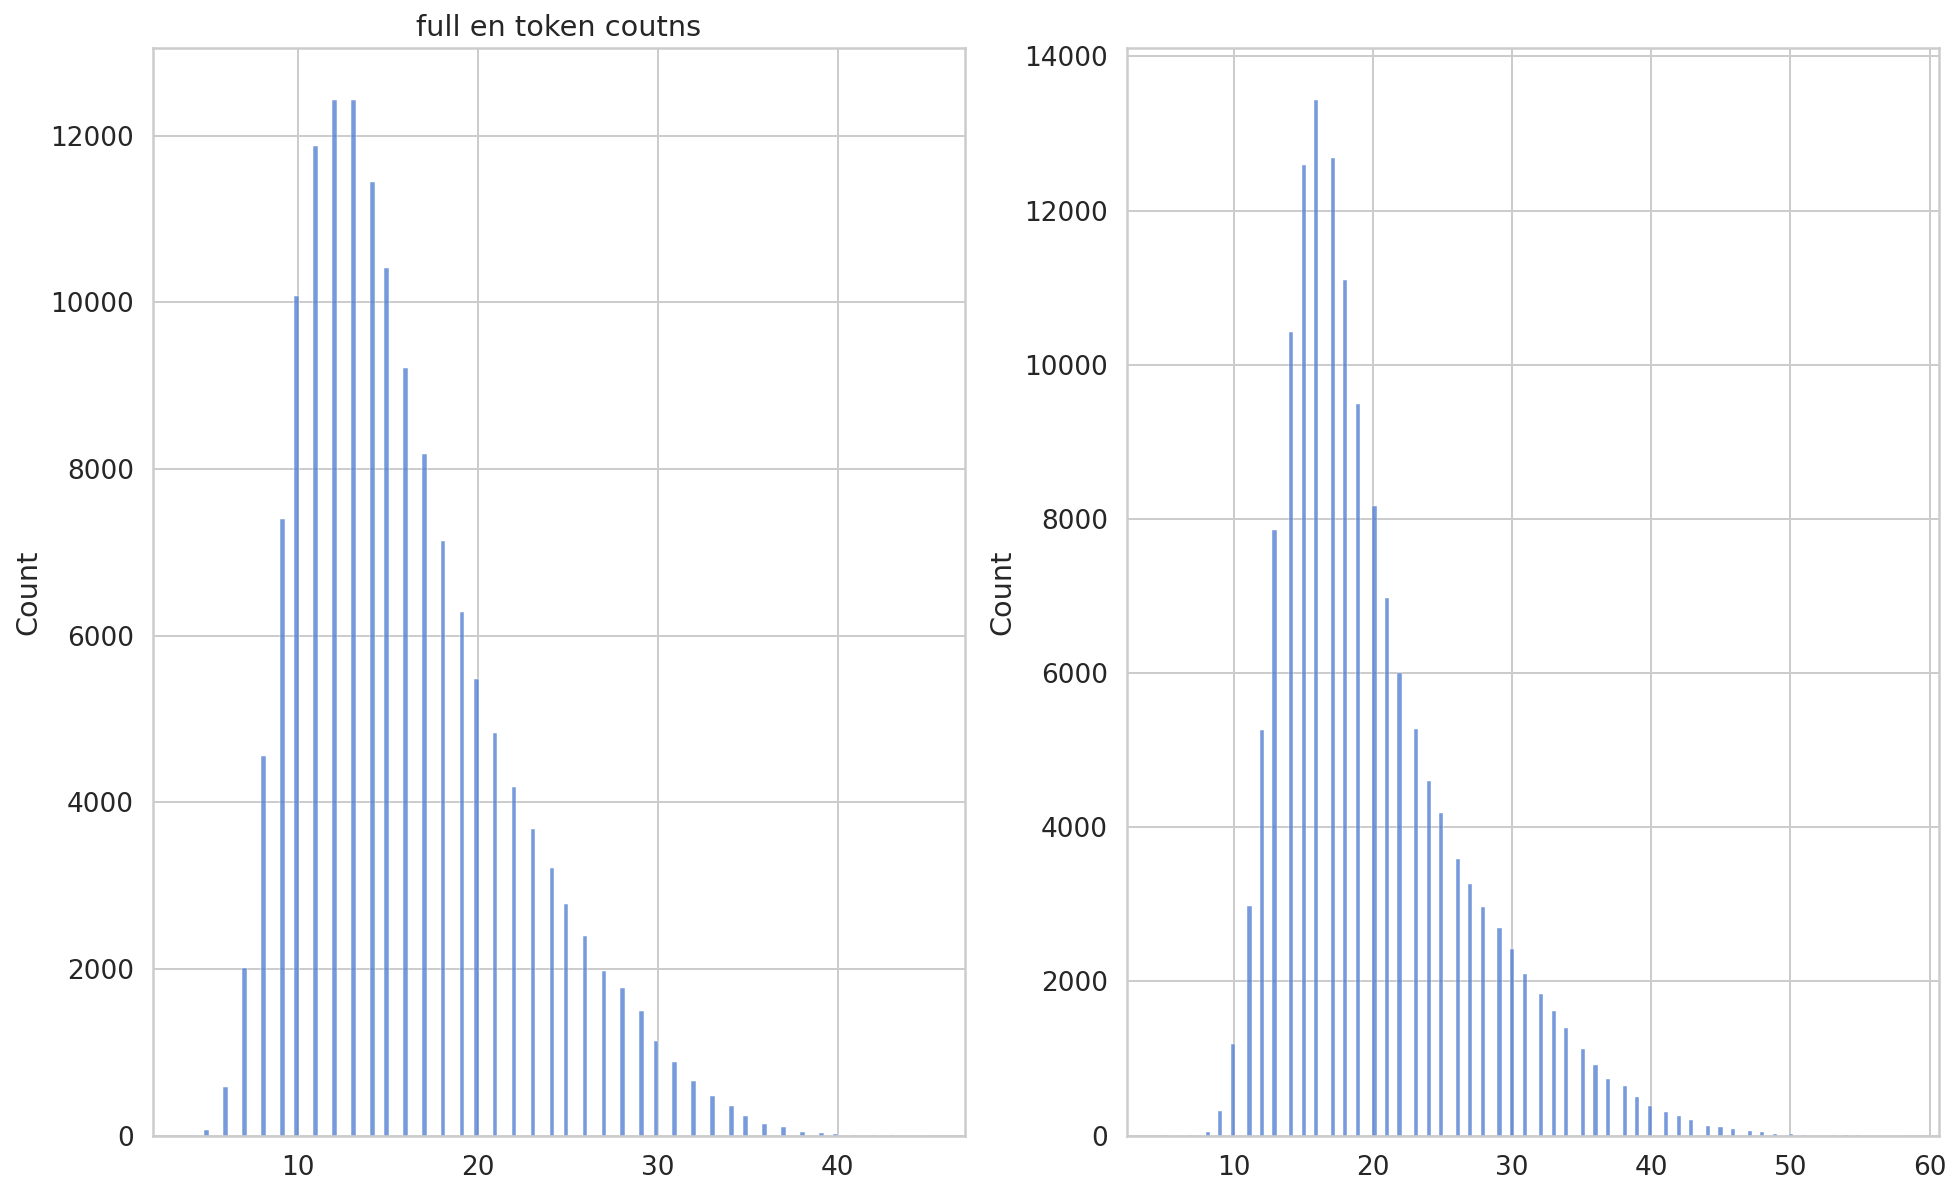

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(en_token_counts, ax=ax1)
ax1.set_title('full en token coutns')
sns.histplot(ko_token_counts, ax=ax2)


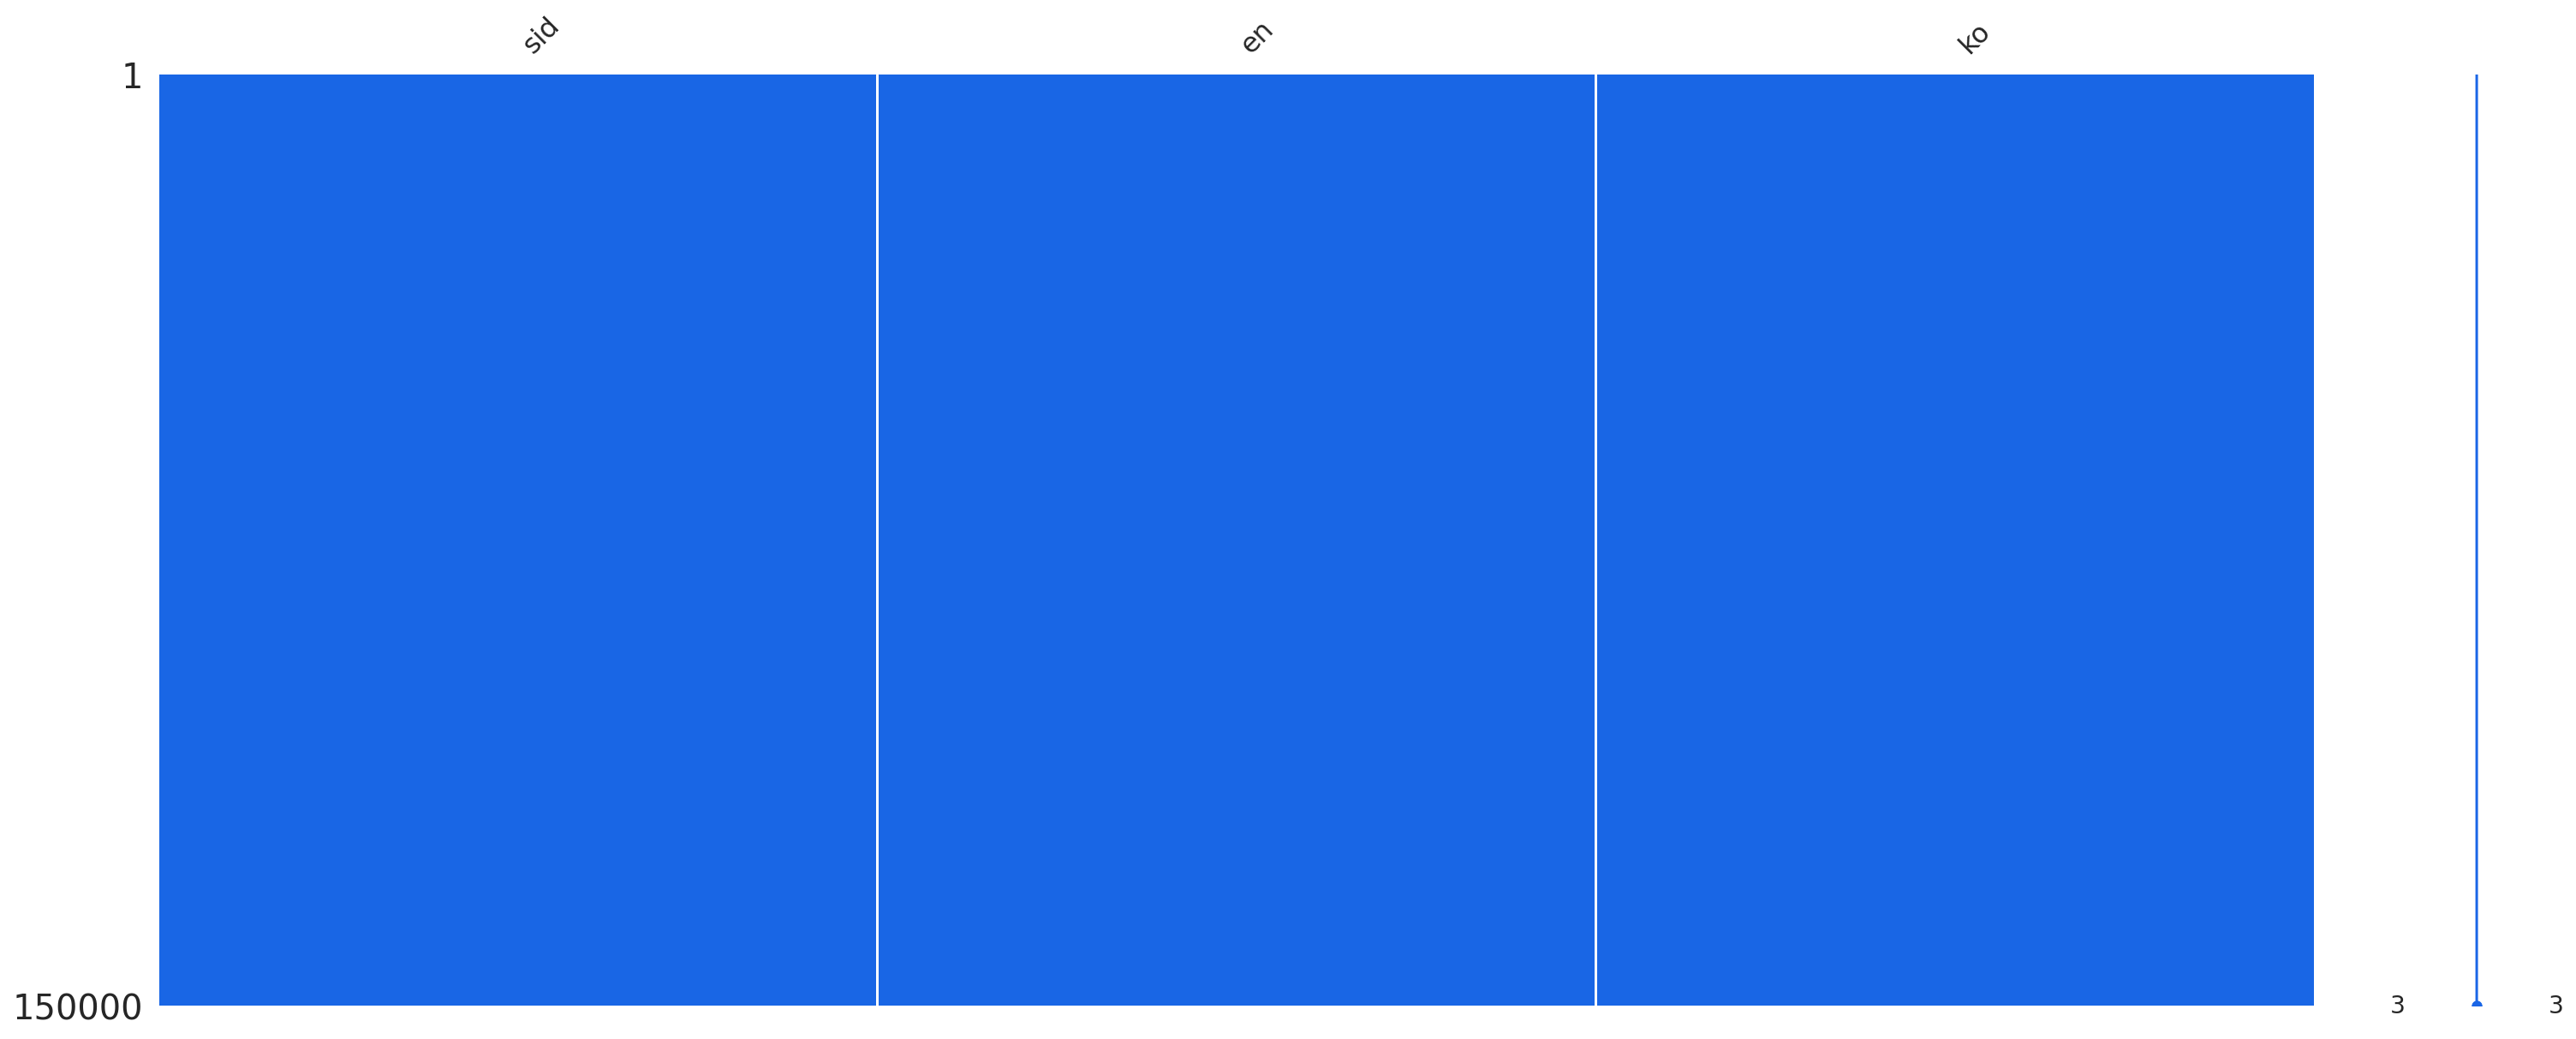

In [ ]:
import missingno as msno

msno.matrix(train, color=(0.1, 0.4, 0.9))

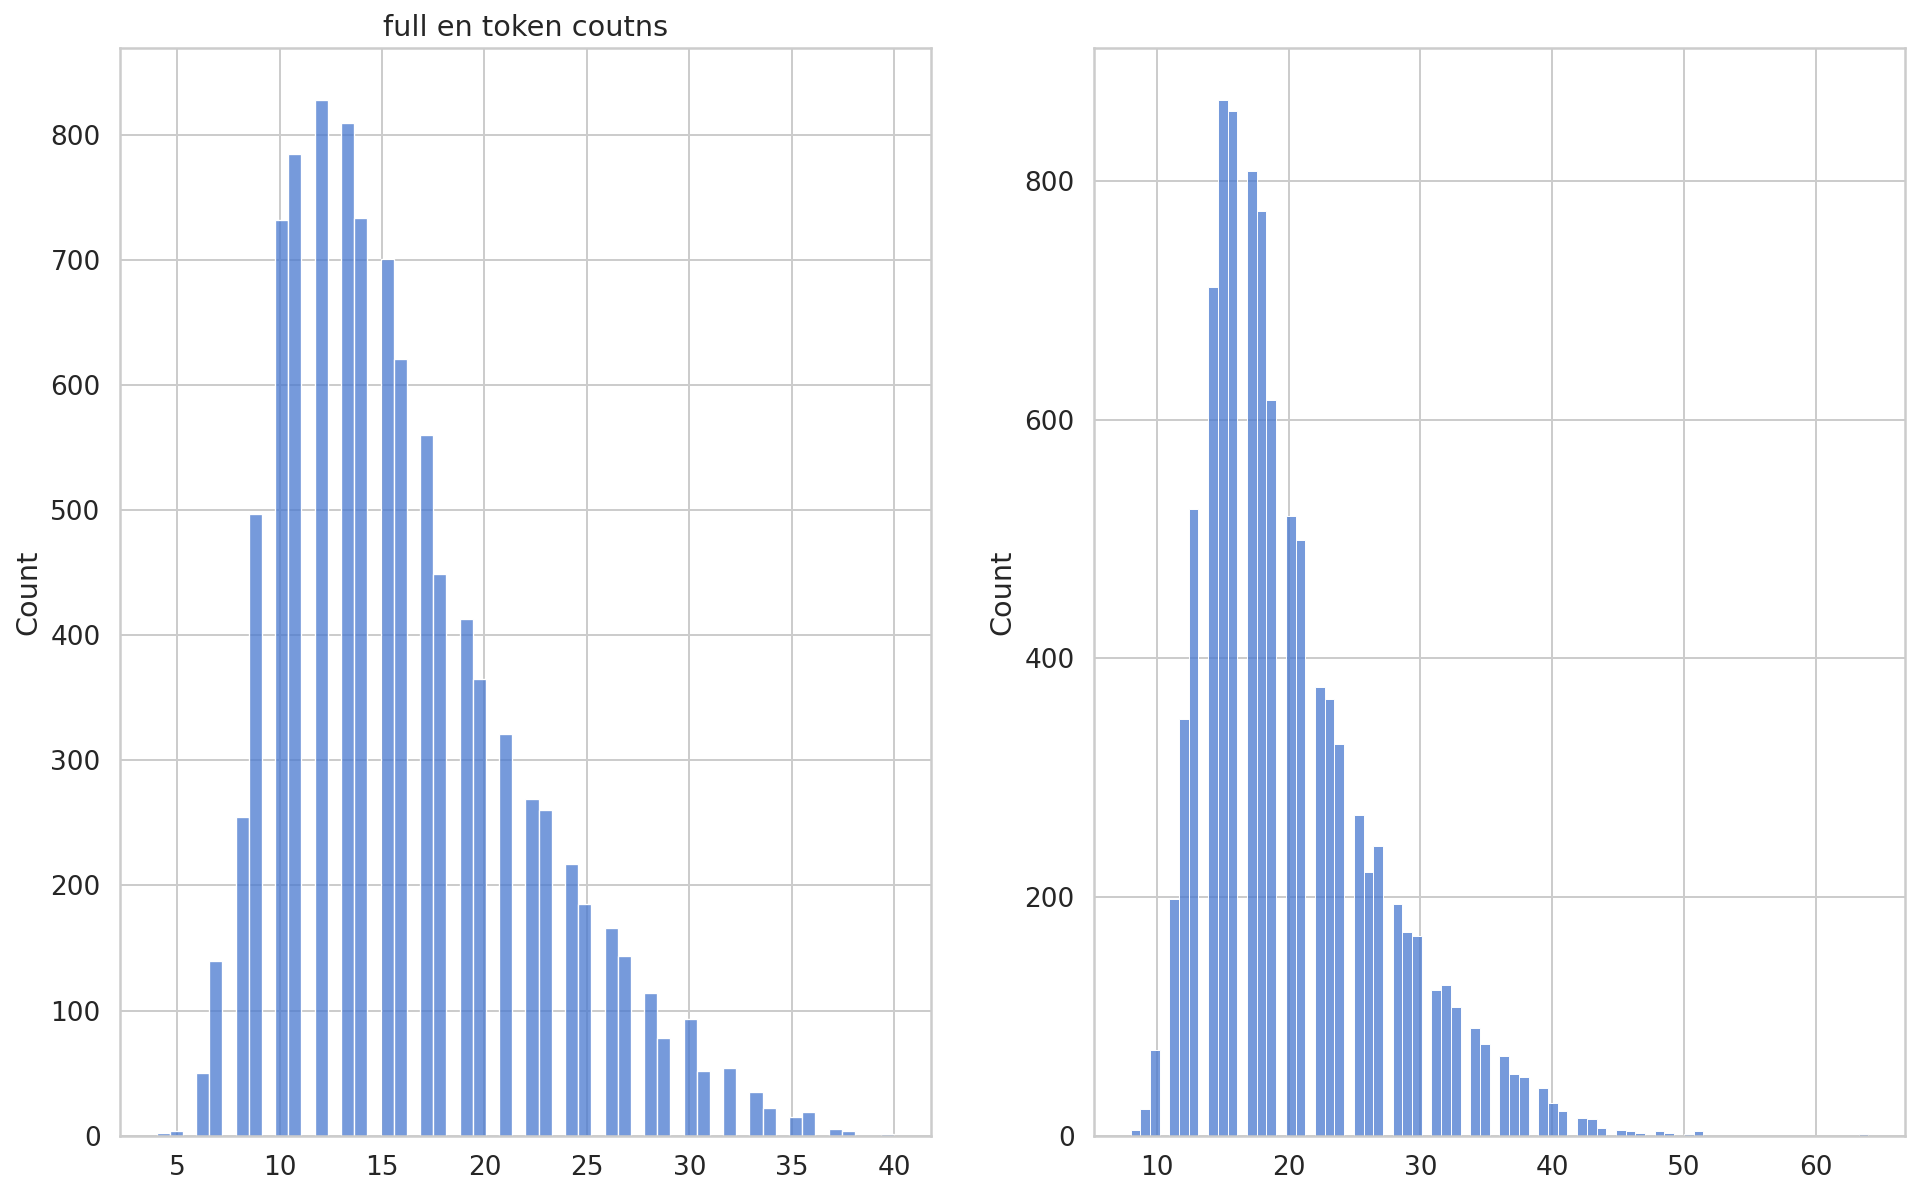

In [ ]:
en_token_counts, ko_token_counts = [], []

for _, row in dev.iterrows():
    en_token_count = len(tokenizer.encode(row['en']))
    en_token_counts.append(en_token_count)

    ko_token_count = len(tokenizer.encode(row['ko']))
    ko_token_counts.append(ko_token_count)
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(en_token_counts, ax=ax1)
ax1.set_title('full en token coutns')
sns.histplot(ko_token_counts, ax=ax2)

In [ ]:
dev.describe()

,sid,en,ko
count,10000,10000,10000
unique,10000,10000,10000
top,dev-6711,Do I need a coin to use this cart?,우리는 병원으로 가는 차 안에서 수시로 연습했어요.
freq,1,1,1


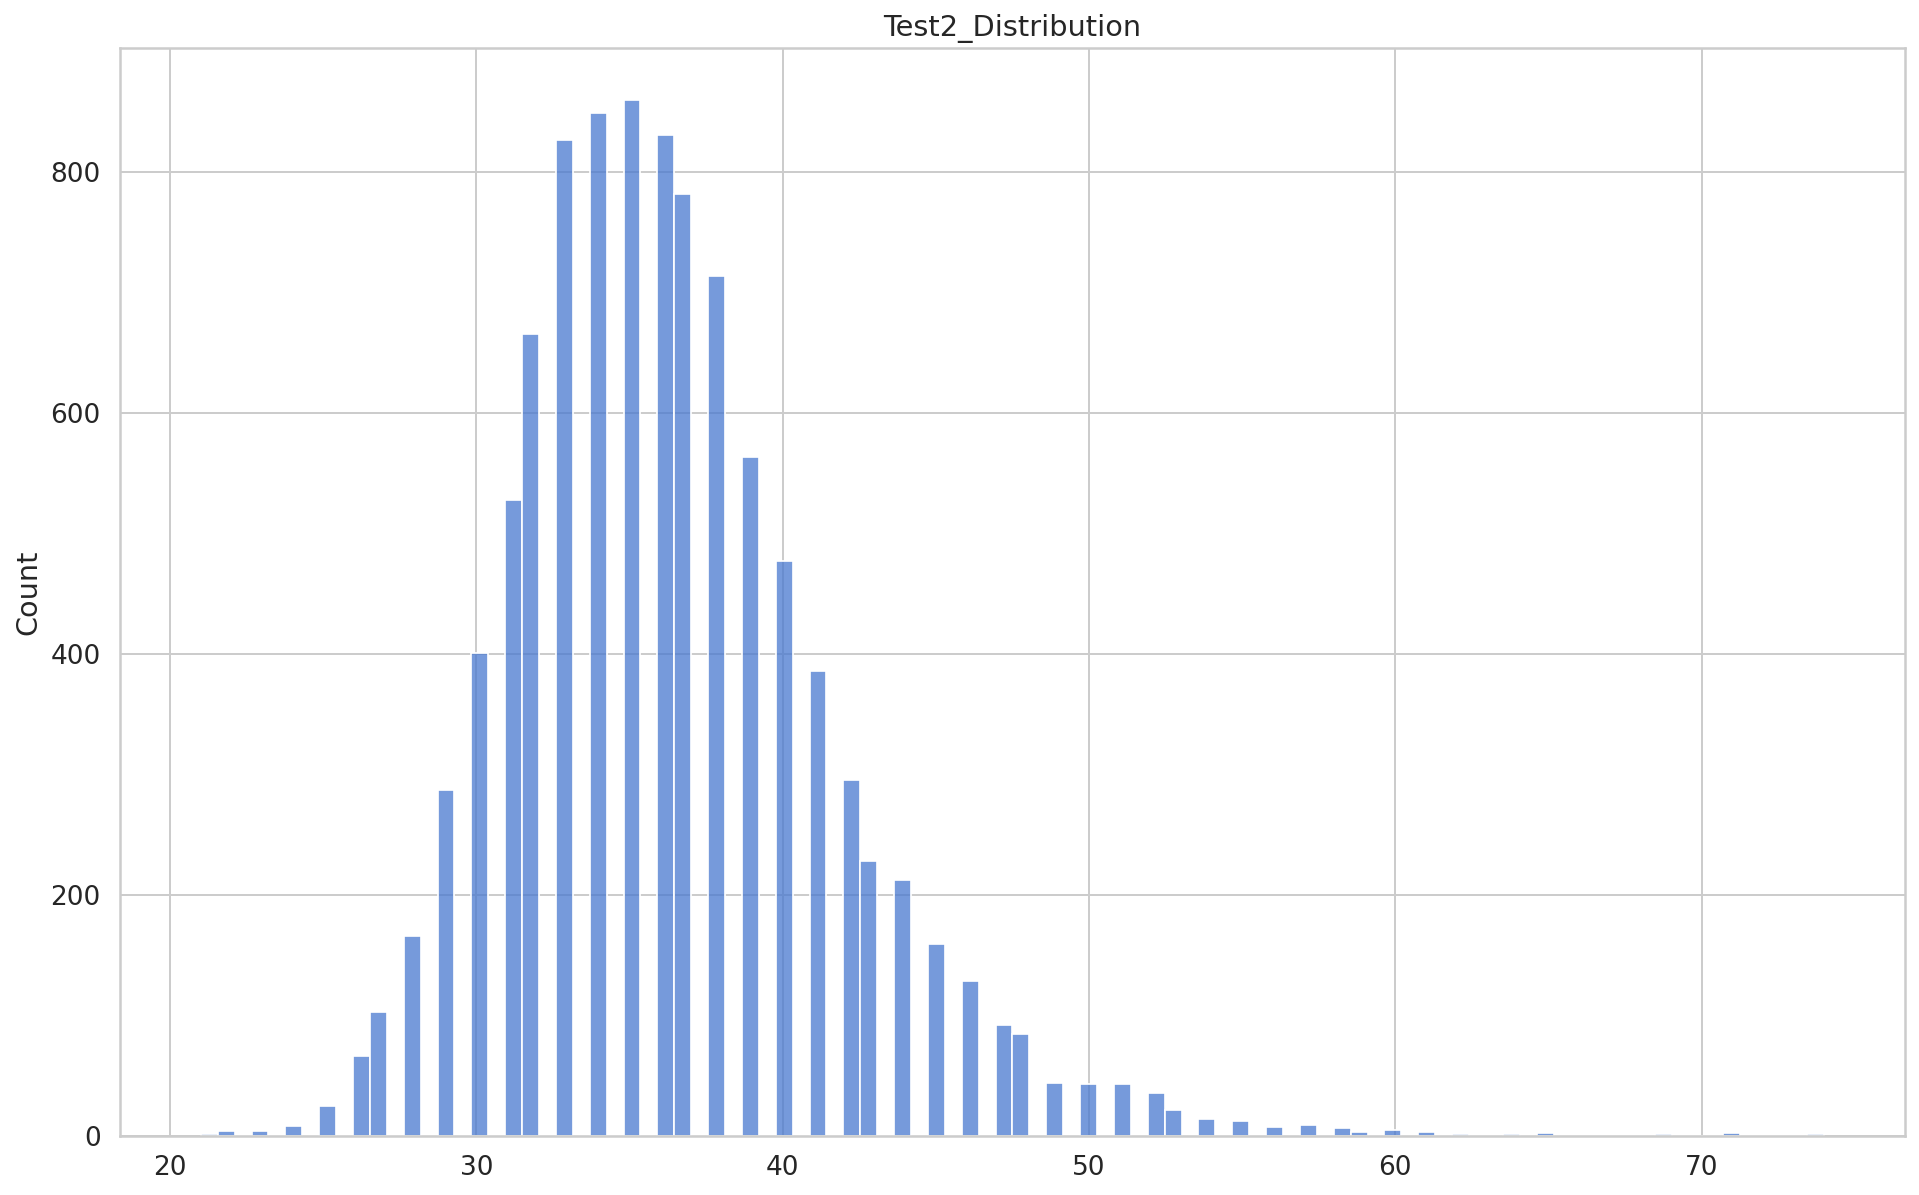

In [ ]:
en_token_counts, ko_token_counts = [], []

for _, row in test2.iterrows():
    en_token_count = len(tokenizer.encode(row['en']))
    en_token_counts.append(en_token_count)
plt.title('Test2_Distribution')
sns.histplot(en_token_counts)

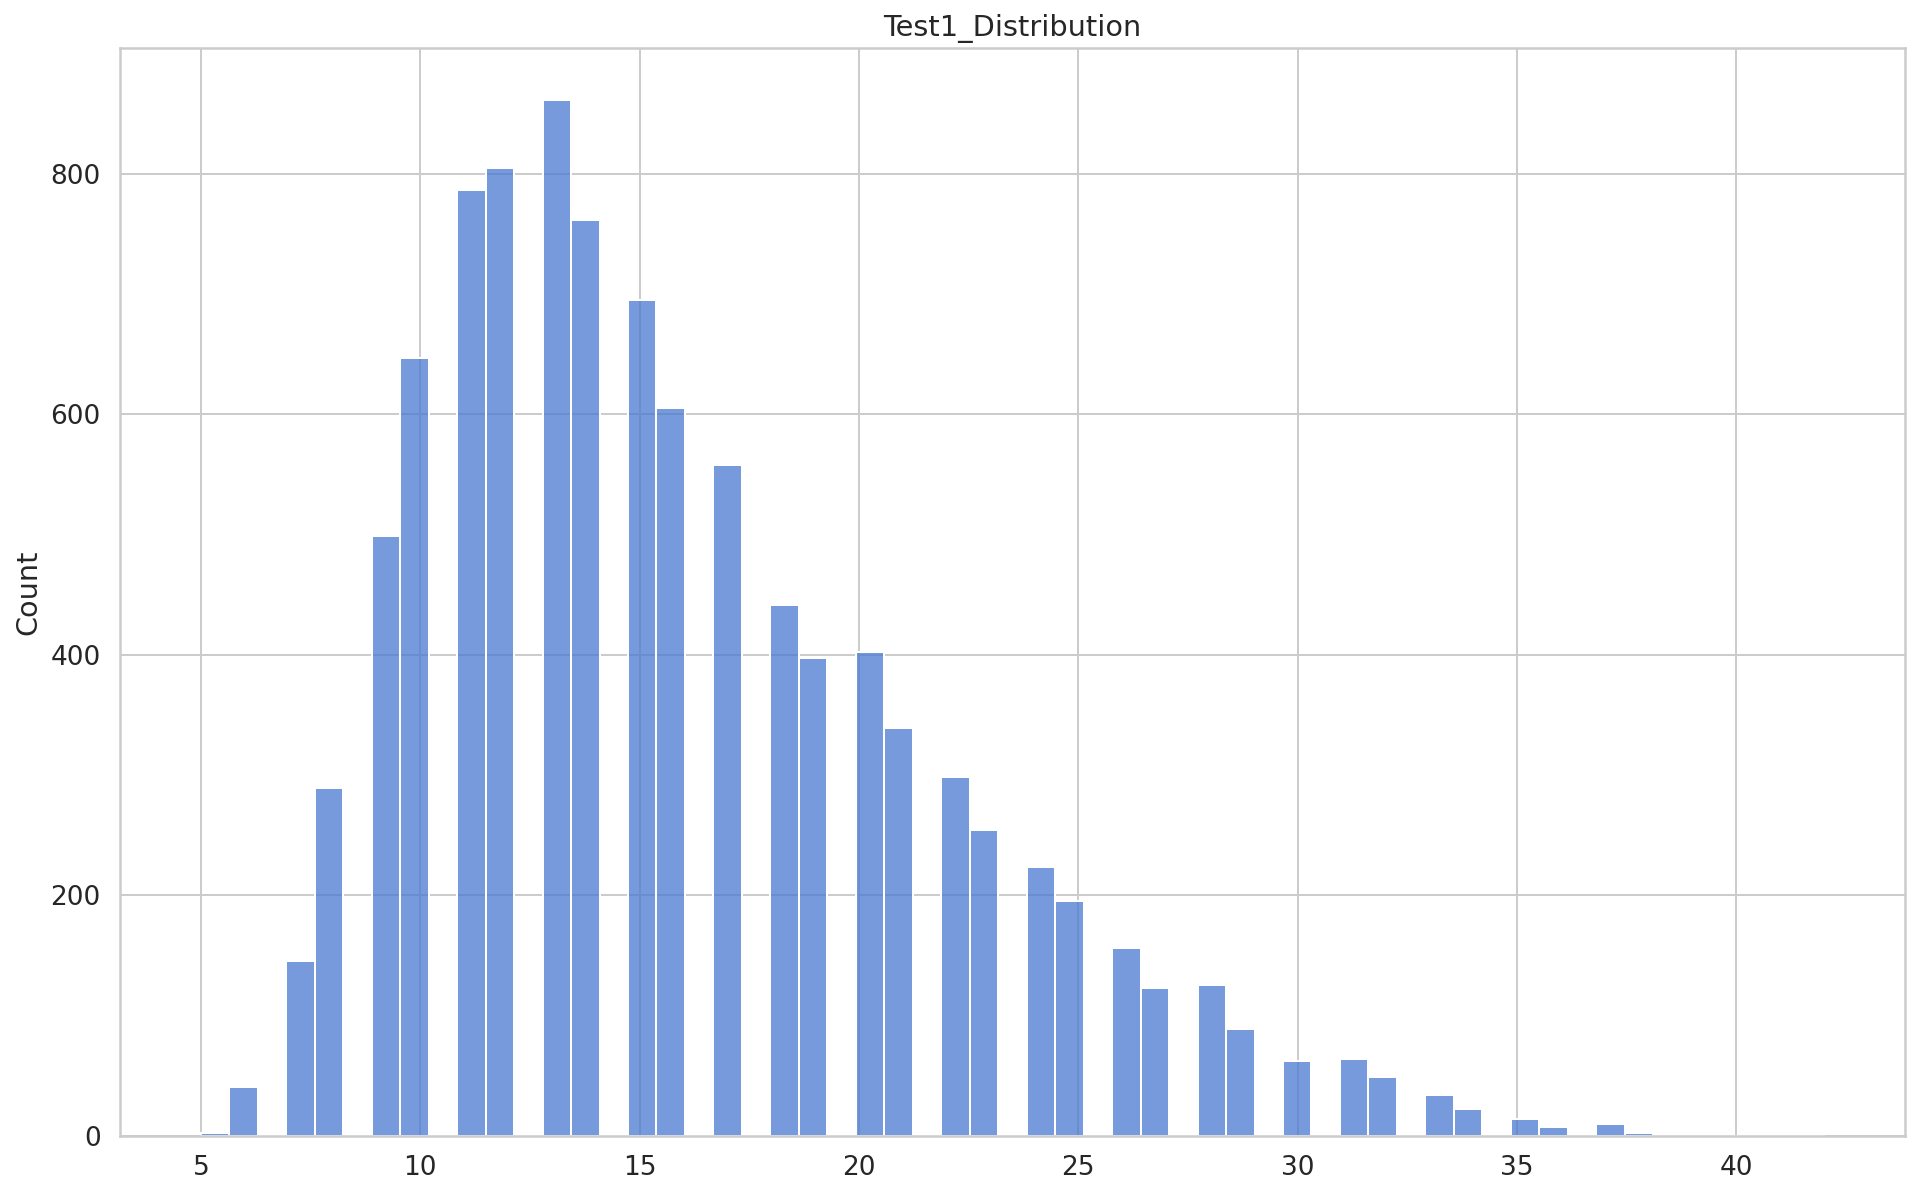

In [ ]:
en_token_counts, ko_token_counts = [], []

for _, row in test.iterrows():
    en_token_count = len(tokenizer.encode(row['en']))
    en_token_counts.append(en_token_count)
plt.title('Test1_Distribution')
sns.histplot(en_token_counts)

In [ ]:
test.describe()

,sid,en
count,10000,10000
unique,10000,10000
top,test-8260,This egg will turn to the real egg.
freq,1,1


In [ ]:
test2.describe()

,sid,en
count,10000,10000
unique,10000,9999
top,test2-5114,By participating in the Korean traditional mus...
freq,1,2


In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 8

In [ ]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MT5ForConditionalGeneration.from_pretrained(MODEL_NAME ,output_attentions=True ,return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids'].to(device)
        attention_mask = batch['text_attention_mask'].to(device)
        labels = batch['labels'].to(device)
        labels_attention_mask = batch['labels_attention_mask'].to(device)

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids'].to(device)
        attention_mask = batch['text_attention_mask'].to(device)
        labels = batch['labels'].to(device)
        labels_attention_mask = batch['labels_attention_mask'].to(device)

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids'].to(device)
        attention_mask = batch['text_attention_mask'].to(device)
        labels = batch['labels'].to(device)
        labels_attention_mask = batch['labels_attention_mask'].to(device)

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)

        return loss


    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.00005) # 0.0001 -> 0.00001-> 0.00005 -> 0.0001 -> 0.00005 

In [ ]:
data_module = NewsSummaryDataModule(train, dev, tokenizer)

In [ ]:
data_module.setup()

In [ ]:
model = NewsSummaryModel()

Downloading:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

In [ ]:
logger = TensorBoardLogger("lightning_logs", name='news-summary')

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

checkpoint_callback = ModelCheckpoint(
    filename="/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min")


In [ ]:
trainer = pl.Trainer(
  logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=10,
    accumulate_grad_batches=2,
    gpus=1,
    #tpu_cores=8,
    progress_bar_refresh_rate=30)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | MT5ForConditionalGeneration | 582 M 
------------------------------------------------------
582 M     Trainable params
0         Non-trainable params
582 M     Total params
2,329.605 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 9374: val_loss reached 1.98226 (best 1.98226), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 18749: val_loss reached 1.65327 (best 1.65327), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 28124: val_loss reached 1.52273 (best 1.52273), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 37499: val_loss reached 1.44923 (best 1.44923), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 46874: val_loss reached 1.40694 (best 1.40694), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 56249: val_loss reached 1.37246 (best 1.37246), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 65624: val_loss reached 1.34863 (best 1.34863), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 74999: val_loss reached 1.33083 (best 1.33083), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 84374: val_loss reached 1.31440 (best 1.31440), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 93749: val_loss reached 1.30891 (best 1.30891), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v1.ckpt" as top 1


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs
#!rm --rf lightning_logs
#/content/lightning_logs

In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    '/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v3.ckpt'
) 
# trained_model.freeze()

Downloading:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

In [ ]:
trainer.fit(trained_model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | MT5ForConditionalGeneration | 582 M 
------------------------------------------------------
582 M     Trainable params
0         Non-trainable params
582 M     Total params
2,329.605 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 9374: val_loss reached 1.38297 (best 1.38297), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 18749: val_loss reached 1.30483 (best 1.30483), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 28124: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 37499: val_loss was not in top 1


In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    '/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v4.ckpt'
) 

In [ ]:
train_dev = dev[:9000]
val_dev = dev[9000:]
val_dev = val_dev.reset_index().drop('index', axis=1)

,sid,en,ko
9000,dev-9000,"Therefore, the Hashima Island has a tragic his...",그렇기에 지옥 섬으로 불릴 정도로 하시마섬은 우리나라의 아픈 역사를 가지고 있는 곳...
9001,dev-9001,I've been suffering in gastritis.,제가 위염에 걸려 고생을 좀 했습니다.
9002,dev-9002,The school ground is used as the filming Site.,학교 운동장은 영화 촬영지로 이용되었다.
9003,dev-9003,This business is really important to me.,이 일은 저에게 정말 매우 중요해요.
9004,dev-9004,A dog is sitting in front of the door.,개 한 마리가 문 앞에 앉아 있어요.
...,...,...,...
9995,dev-9995,"As to GV and event schedule, you can participa...",GV 및 행사 일정은 모두 참석 가능합니다.
9996,dev-9996,What do you think the secret to this show's lo...,이 프로그램의 장수 비결은 뭐라고 생각하세요?
9997,dev-9997,I expressed the M-shaped form that flows in th...,진주 남강의 물의 흐름을 본뜬 M자 형태의 평면 형태 그리고 그 M자 형태의 천장에...
9998,dev-9998,"At that point, I realized that the police woul...","그때, 난 경찰이 아무 도움을 줄 수 없다는 걸 깨달았죠."


In [ ]:
data_module = NewsSummaryDataModule(train_dev, val_dev, tokenizer)

In [ ]:
trainer.fit(trained_model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | MT5ForConditionalGeneration | 582 M 
------------------------------------------------------
582 M     Trainable params
0         Non-trainable params
582 M     Total params
2,329.605 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 562: val_loss reached 1.28525 (best 1.28525), saving model to "/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v6.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 1125: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 1688: val_loss was not in top 1


In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    '/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/best-NMT-v1-v6.ckpt'
) 

Downloading:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

In [ ]:
trained_model = trained_model.to(device)

In [ ]:
def summarizeText(text):
    text_encoding = tokenizer(
        text,
        max_length=60,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'].to(device),
        attention_mask=text_encoding['attention_mask'].to(device),
        max_length=60,
        num_beams=5, # 2->5
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)

In [ ]:
sample_row = test.iloc[2]
text = sample_row['en']
model_summary = summarizeText(text)
text 

'Another major risk of genetically modified food is the environmental impact.'

In [ ]:
model_summary

'유전자 변형식품의 또 다른 주요한 위험은 환경적 영향입니다.'

In [ ]:
for i, j in enumerate(tqdm(test.en)):
  test.loc[i, 'ko'] = summarizeText(j)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
test

,sid,en,ko
0,test-0,I hope nothing happens to you.,당신에게 아무런 일이 없었으면 좋겠어요.
1,test-1,"He'll adapt well, don't worry.",그는 잘 적응할 거니까 걱정하지 마세요.
2,test-2,Another major risk of genetically modified foo...,유전자 변형식품의 또 다른 위험은 환경 영향입니다.
3,test-3,That's not the point.,그것은 의미가 아니에요.
4,test-4,Margin status was defined as either a positive...,마진 상태는 긍정적이나 부정적이라고 정의되었습니다.
...,...,...,...
9995,test-9995,Let's make special memories.,우리 특별한 추억을 만들자.
9996,test-9996,Is there any top player in the world ranking?,세계랭킹에서 최고의 선수가 있나요?
9997,test-9997,The title of the second series of this show is...,이 시리즈의 두 번째 시리즈의 제목은 Salto Motale입니다.
9998,test-9998,The product is a gray melange fabric with a gr...,이 제품은 회색 메말린 원단으로 녹색 컬러 스케치가 적용되어 있습니다.


In [ ]:
test.to_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/result3.test1.csv', index=False)

In [ ]:
for i, j in enumerate(tqdm(test2.en)):
  test2.loc[i, 'ko'] = summarizeText(j)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
test2.to_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/result3.test2.csv', index=False)

In [ ]:
test2

,sid,en,ko
0,test2-0,They were chosen as the chief husband and the ...,그들은 친절하고 용감하고 지혜로워서 Skull Tribe의 주인공으로 선정되었습니다.
1,test2-1,So I stopped the process of preparing my under...,그래서 저는 학부과정을 중단하고 처음부터 배워나가기 위해 기초과정으로 돌아갔습니다.
2,test2-2,"Accordingly, the food boiled down in soy sauce...",따라서 칸토 지역에서 간장이나 다른 양념에 삶은 음식은 질이 많고 형태를 유지하기가...
3,test2-3,"According to statistics, office workers only u...","통계청에 따르면, 직장인들은 일상생활을 위해 차량을 하루에 2시간만 사용한다고 합니다."
4,test2-4,It's the impact of a group art therapy using c...,흙을 사용한 집단 예술 치료가 정신적 불량 아이들의 집중력 증가와 자기 표현에 미치...
...,...,...,...
9995,test2-9995,So you just need to get on the bus with an eas...,"그래서 당신은 편하게 버스를 타고 출발하면 운전자가 '출발해야 할 분, 내려주세요'..."
9996,test2-9996,The Pyeongchang Olympics held by South Korea 3...,1998년 서울 올림픽이 개최된 후 30년 만에 한국에서 열린 평창올림픽은 스포츠를...
9997,test2-9997,"Hello, this is Ki Tae who is checking in Angsa...","안녕하세요, 2017년 2월 21일 오전 10시에 대만국제공항에 도착하여 김포공항에..."
9998,test2-9998,Cotton thread is manufactured in order of remo...,면털은 미세먼지를 없애기 위해 여러 종류의 원단을 적당한 비율에 섞어서 부드러운 면...


In [ ]:
for i, j in enumerate(tqdm(dev.en)):
  dev.loc[i, 'Predict'] = summarizeText(j)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
dev.to_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/result1.dev.csv', index=False)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
reference = dev['ko']
candidate = dev['Predict']


score4 = sentence_bleu(dev.ko[0], dev.Predict[0], weights=(0, 0, 0, 1))

In [ ]:
for i in range(len(dev)):
  dev.loc[i, 'Blue_score'] = sentence_bleu(dev.ko[i], dev.Predict[i])

In [ ]:
dev['Blue_score'].mean()

0.8437753964699163

In [ ]:
for i, j in enumerate(tqdm(val_dev.en)):
  val_dev.loc[i, 'Predict'] = summarizeText(j)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for i in range(len(val_dev)):
  val_dev.loc[i, 'Blue_score'] = sentence_bleu(val_dev.ko[i], val_dev.Predict[i])

In [ ]:
val_dev['Blue_score'].mean()

0.840421929475615

In [ ]:
val_dev

,sid,en,ko,Predict,Blue_score
0,dev-9000,"Therefore, the Hashima Island has a tragic his...",그렇기에 지옥 섬으로 불릴 정도로 하시마섬은 우리나라의 아픈 역사를 가지고 있는 곳...,따라서 하사마섬은 우리나라의 비극적인 역사를 가지고 있습니다.,0.852999
1,dev-9001,I've been suffering in gastritis.,제가 위염에 걸려 고생을 좀 했습니다.,저는 위염으로 고생하고 있어요.,0.770771
2,dev-9002,The school ground is used as the filming Site.,학교 운동장은 영화 촬영지로 이용되었다.,학교 땅은 촬영지로 사용됩니다.,0.896883
3,dev-9003,This business is really important to me.,이 일은 저에게 정말 매우 중요해요.,이 사업은 저에게 매우 중요합니다.,0.872288
4,dev-9004,A dog is sitting in front of the door.,개 한 마리가 문 앞에 앉아 있어요.,개가 문 앞에 앉아 있습니다.,0.889140
...,...,...,...,...,...
995,dev-9995,"As to GV and event schedule, you can participa...",GV 및 행사 일정은 모두 참석 가능합니다.,GV와 이벤트 일정은 당신이 모든 것에 참여할 수 있습니다.,0.759836
996,dev-9996,What do you think the secret to this show's lo...,이 프로그램의 장수 비결은 뭐라고 생각하세요?,이 쇼의 긴장 비밀은 무엇이라고 생각하세요?,0.873935
997,dev-9997,I expressed the M-shaped form that flows in th...,진주 남강의 물의 흐름을 본뜬 M자 형태의 평면 형태 그리고 그 M자 형태의 천장에...,"나는 진주의 남강에서 흐르는 M 형태를 표현했고, M형식 천장에 파란 하늘을 더했습니다.",0.799298
998,dev-9998,"At that point, I realized that the police woul...","그때, 난 경찰이 아무 도움을 줄 수 없다는 걸 깨달았죠.",그때 경찰이 우리에게 전혀 도움을 주지 않는다는 것을 깨달았습니다.,0.797944


In [ ]:
dev[9000:]

,sid,en,ko
9000,dev-9000,"Therefore, the Hashima Island has a tragic his...",그렇기에 지옥 섬으로 불릴 정도로 하시마섬은 우리나라의 아픈 역사를 가지고 있는 곳...
9001,dev-9001,I've been suffering in gastritis.,제가 위염에 걸려 고생을 좀 했습니다.
9002,dev-9002,The school ground is used as the filming Site.,학교 운동장은 영화 촬영지로 이용되었다.
9003,dev-9003,This business is really important to me.,이 일은 저에게 정말 매우 중요해요.
9004,dev-9004,A dog is sitting in front of the door.,개 한 마리가 문 앞에 앉아 있어요.
...,...,...,...
9995,dev-9995,"As to GV and event schedule, you can participa...",GV 및 행사 일정은 모두 참석 가능합니다.
9996,dev-9996,What do you think the secret to this show's lo...,이 프로그램의 장수 비결은 뭐라고 생각하세요?
9997,dev-9997,I expressed the M-shaped form that flows in th...,진주 남강의 물의 흐름을 본뜬 M자 형태의 평면 형태 그리고 그 M자 형태의 천장에...
9998,dev-9998,"At that point, I realized that the police woul...","그때, 난 경찰이 아무 도움을 줄 수 없다는 걸 깨달았죠."


In [ ]:
dev

,sid,en,ko
0,dev-0,Match up with Hello Carbot Megabold versus Met...,헬로카봇 메가볼들 대 매트론 K 컵스와의 대결이에요.
1,dev-1,Mr.Park sends his regards.,미스터 박이 대신 안부 전해 달라더군요.
2,dev-2,I wrote a story to become an editor.,저는 편집자가 되기 위해 이야기를 썼습니다.
3,dev-3,That's not what I'm thinking.,그것은 내가 생각한 것이 아닙니다.
4,dev-4,Who will you give the food?,당신은 그 음식을 누구에게 줄 것입니까?
...,...,...,...
9995,dev-9995,"As to GV and event schedule, you can participa...",GV 및 행사 일정은 모두 참석 가능합니다.
9996,dev-9996,What do you think the secret to this show's lo...,이 프로그램의 장수 비결은 뭐라고 생각하세요?
9997,dev-9997,I expressed the M-shaped form that flows in th...,진주 남강의 물의 흐름을 본뜬 M자 형태의 평면 형태 그리고 그 M자 형태의 천장에...
9998,dev-9998,"At that point, I realized that the police woul...","그때, 난 경찰이 아무 도움을 줄 수 없다는 걸 깨달았죠."


In [ ]:
train

,sid,en,ko
0,train-0,Just use a LinearLayout instead.,그 대신 Linear Layout을 쓰는 게 낫다.
1,train-1,I made a seventy-eight today.,저는 오늘 78타를 쳤습니다.
2,train-2,I thought the concert was boring.,나는 그 연주회가 지루하다고 생각했어요.
3,train-3,You can buy ramen at any store that deals with...,라면은 식료품을 취급하는 어느 상점에서나 구할 수 있습니다.
4,train-4,I prayed that you're not sick.,네가 아픈 게 아니길 기도를 했습니다.
...,...,...,...
149995,train-149995,Please tell me again the address you're going to.,가시는 곳 주소를 다시 알려주십시오.
149996,train-149996,What were the fundamental questions you tried ...,당신이 우리의 관계 안에서 해결하려 한 근본 질문들은 무엇이었는가?
149997,train-149997,A young child should not do ballet and at the ...,어린아이가 발레를 하면서 과도한 근육운동과 움직임을 해서는 안 됩니다.
149998,train-149998,You cannot describe how great the feelings are...,활을 쏘고 중앙에 맞추는 기분은 말로 표현할 수 없지요.


In [ ]:
for i, j in enumerate(tqdm(train.en)):
  train.loc[i, 'Predict'] = summarizeText(j)

  0%|          | 0/150000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
train.to_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/NMT/result1.train.csv', index=False)

In [ ]:
train

,sid,en,ko,Predict
0,train-0,Just use a LinearLayout instead.,그 대신 Linear Layout을 쓰는 게 낫다.,대신 Linear Layout을 사용하세요.
1,train-1,I made a seventy-eight today.,저는 오늘 78타를 쳤습니다.,저는 오늘 78세를 했습니다.
2,train-2,I thought the concert was boring.,나는 그 연주회가 지루하다고 생각했어요.,나는 그 콘서트가 지루하다고 생각했어요.
3,train-3,You can buy ramen at any store that deals with...,라면은 식료품을 취급하는 어느 상점에서나 구할 수 있습니다.,라면은 음식물을 판매하는 어느 가게에서나 살 수 있습니다.
4,train-4,I prayed that you're not sick.,네가 아픈 게 아니길 기도를 했습니다.,당신이 아프지 않기를 기도했어요.
...,...,...,...,...
149995,train-149995,Please tell me again the address you're going to.,가시는 곳 주소를 다시 알려주십시오.,NaN
149996,train-149996,What were the fundamental questions you tried ...,당신이 우리의 관계 안에서 해결하려 한 근본 질문들은 무엇이었는가?,NaN
149997,train-149997,A young child should not do ballet and at the ...,어린아이가 발레를 하면서 과도한 근육운동과 움직임을 해서는 안 됩니다.,NaN
149998,train-149998,You cannot describe how great the feelings are...,활을 쏘고 중앙에 맞추는 기분은 말로 표현할 수 없지요.,NaN
